## Berechnung von Magnetfeldern von stromdurchflossenen Leitern am Beispiel der Helmholzspule

Im ersten Teil des Programms werden die Klassen für Leiter ```Wire```, dem Diskretisier ```Discretizer``` und dem Biot-Savart Löser ```BBSolver``` definiert.


In [2]:
'''
Simple Biot Savart Solver for arbitrarily shaped wires
Copyright (C) 2012  Antonio Franco (antonio_franco@live.it)
This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
'''

from numpy import array,pi,cos,sin,r_,linspace,zeros,concatenate,append,linalg,cross
import cmath
from math import floor

class Wire:
    '''
    Implements an arbitrary shaped wire
    '''
    coordz = []
    '''Coordinates of the vertex of the wire in the form [X,Y,Z]'''
    I = complex(1,0)
    '''Complex current carried by the wire'''
    def __init__(self):
        '''By default initited as a toroidal coil with
            R1 = 10
            R2 = 1
            N = 100
            step = 0.001
            and current 1A with 0 phase
        '''
        R1 = 10
        R2 = 1
        N = 100
        step = 0.001
        self.Create_Toroidal_Coil(R1, R2, N, step)
        self.Set_Current(1, 0)
        return

    def Set_Current(self,modulus,angle):
        '''Sets current with absolute value modulus and phase angle (in radians)'''
        self.I = cmath.rect(modulus,angle)
        return

    def addWire(self, Wire):
        '''
        Adds the coordinates of the second class to this one. Both have to have the same current
        '''
        X,Y,Z = self.coordz
        Xo, Yo,Zo = Wire.coordz
        self.coordz = [r_[X,Xo], r_[Y,Yo],r_[Z,Zo]]
        return

    def Create_Toroidal_Coil(self, R1 , R2 , N , step ):
        '''
        Create_Toroidal_Coil( R1 , R2 , N , step )
        Creates a toroidal coil of major radius R1, minor radius R2 with N
         turns and a step step
         Initiates coordz
        '''
        a=R1
        b=R2
        c=N

        t=r_[0:2*pi:step]

        X=(a+b*sin(c*t))*cos(t);
        Y=(a+b*sin(c*t))*sin(t);
        Z=b*cos(c*t);

        self.coordz = [X,Y,Z]

        return

    def Create_Solenoid(self, R , N , l , step ):
        '''
        Create_Solenoid(self, R , N , l , step )
        Creates a solenoid whose length is l with radius R, N turns with step
        step along the z axis
        '''
        a = R;
        b = l/(2*pi*N);
        T = l/b;

        t=r_[0:T:step]

        X = a*cos(t);
        Y = a*sin(t);
        Z = b*t;

        self.coordz = [X,Y,Z]
        return

    def Create_Loop(self,center,radius,NOP,Orientation='xy'):
        '''
        Create_Loop(self,center,radius,NOP)
        a circle with center defined as
        a vector CENTER, radius as a scaler RADIS. NOP is
        the number of points on the circle.
        '''
        t=linspace(0,2*pi,NOP)

        if Orientation == 'xy':
            X = center[0]+radius*sin(t)
            Y = center[1]+radius*cos(t)
            Z = center[2]+zeros(NOP)
        elif Orientation == 'xz':
            X = center[0]+radius*sin(t)
            Y = center[1]+zeros(NOP)
            Z = center[2]+radius*cos(t)
        elif Orientation == 'yz':
            X = center[0]+zeros(NOP)
            Y = center[1]+radius*sin(t)
            Z = center[2]+radius*cos(t)

        self.coordz = [X,Y,Z]
        return



    def AugmentWire(self,Theta,Phi,length,Origin=None):
        '''
        AugmentWire(self,Theta,Phi,length,Origin=None)
        augments the existing wire by a segment lenght long, starting from point
        Origin, with inclination Theta and Azimuth Phi. If origin = None then the last
        calculated vertex is used
        '''

        #If an origin is not specified, the last vertex is assumed as origin
        if Origin is not None:
            newWire = self.__Create_Wire(Origin, Theta, Phi, length)
        else:
            temp = array(self.coordz)
            newOrigin = temp[:,-1]
            newWire = self.__Create_Wire(newOrigin, Theta, Phi, length)

        #If no coordinates are present, then we simply put the new vertices in the list
        if len(self.coordz)==0:
            self.coordz = newWire
        elif Origin is not None:
            X = concatenate((self.coordz[0],newWire[0]),axis = 1)
            Y = concatenate((self.coordz[1],newWire[1]),axis = 1)
            Z = concatenate((self.coordz[2],newWire[2]),axis = 1)
            self.coordz = [X,Y,Z]
        else:
            X = append(self.coordz[0],newWire[0][1])
            Y = append(self.coordz[1],newWire[1][1])
            Z = append(self.coordz[2],newWire[2][1])
            self.coordz = [X,Y,Z]

        return

    def __Create_Wire(self,Origin,Theta,Phi,length):
        '''
        Create_Wire(self,Origin,Theta,Phi,length)
        creates a single wire lenght long, starting from point
        Origin, with inclination Theta and Azimuth Phi and
        returns its coordinates in the form [X,Y,Z]
        '''

        #Computes the unit vector
        ux = cos(Phi)*sin(Theta)
        uy = sin(Phi)*sin(Theta)
        uz = cos(Theta)

        u = array([ux,uy,uz])

        #Computes the second vertex
        P2 = Origin + length * u

        X = array([Origin[0],P2[0]])
        Y = array([Origin[1],P2[1]])
        Z = array([Origin[2],P2[2]])

        return [X,Y,Z]

    def Create_Wire(self,Origin,Theta,Phi,length):
        '''
        Create_Wire(self,Origin,Theta,Phi,length)
        creates a single wire lenght long, starting from point
        Origin, with inclination Theta and Azimuth Phi and
        returns its coordinates in the form [X,Y,Z]
        '''
        #Computes the unit vector
        ux = cos(Phi)*sin(Theta)
        uy = sin(Phi)*sin(Theta)
        uz = cos(Theta)

        u = array([ux,uy,uz])

        #Computes the second vertex
        P2 = Origin + length * u

        X = array([Origin[0],P2[0]])
        Y = array([Origin[1],P2[1]])
        Z = array([Origin[2],P2[2]])

        self.coordz = [X,Y,Z]
        return

    def plotme(self):
        '''Plots itself
        inactive until ShowPlots is called'''
        import pylab as p
        import mpl_toolkits.mplot3d.axes3d as p3

        X = self.coordz[0]
        Y = self.coordz[1]
        Z = self.coordz[2]

        fig=p.figure(None)
        ax = p3.Axes3D(fig)

        ax.plot(X,Y,Z)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        self.axis_equal(ax)

        p.draw()

        return ax

    def axis_equal(self,ax):
        '''Makes axis the same size'''
        X = self.coordz[0]
        Y = self.coordz[1]
        Z = self.coordz[2]

        Xmax = max(X)
        Ymax = max(Y)
        Zmax = max(Z)

        maxx = max(Xmax,Ymax,Zmax)

        ax.set_xlim3d(min(X),maxx)
        ax.set_ylim3d(min(Y),maxx)
        ax.set_zlim3d(min(Z),maxx)
        return

    def ShowPlots(self):
        '''Triggers pylab.show()'''
        import pylab as p

        p.show()
        return
    
class Discretizer(object):
    '''
    Discretizes a wire
    '''


    def __init__(self):
        '''
        Nothing
        '''
        return
    
    def plotme(self,ax,dSegment):
        X = dSegment[0]
        Y = dSegment[1]
        Z = dSegment[2]
        
        ax.plot(X,Y,Z,'x')
        return
        
    def Discretize_Uniform(self,myWire,dL,n):
        '''
        Discretizes the n-th segment of myWire in chuncks of length
        dL returning them in an array. n is zero based and represent the segment
        composed by the n-th vertex and the n+1-th vertex
        '''
        if len(myWire.coordz[0]) < n+1:
            return []
        
        Segment = [array([myWire.coordz[0][n],myWire.coordz[0][n+1]]),array([myWire.coordz[1][n],myWire.coordz[1][n+1]]),array([myWire.coordz[2][n],myWire.coordz[2][n+1]])]
        
        #Segment vector calculation
        ux = Segment[0][1]-Segment[0][0] 
        uy = Segment[1][1]-Segment[1][0]        
        uz = Segment[2][1]-Segment[2][0]
        
        u = array([ux,uy,uz])
        
        SegmentLength = linalg.norm(u)
        
        #Segment shorter than dL
        if SegmentLength<dL:
            return Segment 
        
        #How many segments?
        lengthRatio = SegmentLength/dL
        nSegments = floor(lengthRatio)
        
        dSegmentx = array([Segment[0][0]])
        dSegmenty = array([Segment[1][0]])
        dSegmentz = array([Segment[2][0]])
                    
        #length vector calculation
        v=dL*u/linalg.norm(u)        
            
        for i in range (1, int(nSegments)+1):
            dSegmentx=append(dSegmentx,dSegmentx[i-1]+v[0])
            dSegmenty=append(dSegmenty,dSegmenty[i-1]+v[1])
            dSegmentz=append(dSegmentz,dSegmentz[i-1]+v[2])
                 
        if nSegments != lengthRatio:
            dSegmentx=append(dSegmentx,Segment[0][1])
            dSegmenty=append(dSegmenty,Segment[1][1])
            dSegmentz=append(dSegmentz,Segment[2][1])
            
        dSegment = [dSegmentx,dSegmenty,dSegmentz]
                    
        return dSegment
    


class BSSolver(object):
    '''
    Calculates the B field at given points for a Wire arbitrarily shaped
    '''


    def __init__(self):
        '''
        Nothing is a static class
        '''
        return
    
    def Solve(self,myWire,points,dL):
        '''
        Solves the B field at points points for a given wire myWire discretized uniformly
        at a length dL
        '''
        B = zeros((len(points[0]),3))
        Discr = Discretizer()
        
        for i in range (0, int(len(myWire.coordz[0]))-1):
            dSegment=Discr.Discretize_Uniform(myWire, dL, i)
            for p in range (0,int(len(points[0]))):  
                point = array([points[0][p],points[1][p],points[2][p]])
                B[p] = B[p] + self.__solveSegment(dSegment, point, myWire.I)
        
        return B
    
    def __solveSegment(self,dSegment,point,I_complex):
        '''
        Solves B in a given point for a given discretized Segment
        '''
        B = zeros((1,3))
        
        for i in range (0, int(len(dSegment[0]))-1):
            dL = [array([dSegment[0][i],dSegment[1][i],dSegment[2][i]]),array([dSegment[0][i+1],dSegment[1][i+1],dSegment[2][i+1]])]
            B = B + self.__dB(dL, point, I_complex)
        
        return B
    
    def __dB(self,dL,point,I_complex):      
        '''
        Solves dB according to Biot Savart
        '''       
        #Magnetic permittivity of the vacuum
        mu = 4*pi*1e-7;
        
        #Wire vector calculation
        ux = dL[1][0]-dL[0][0] 
        uy = dL[1][1]-dL[0][1]        
        uz = dL[1][2]-dL[0][2]
        
        vdL = array([ux,uy,uz])
        
        #Reference point in the middle of the segment
        ux = (dL[1][0]+dL[0][0])/2 
        uy = (dL[1][1]+dL[0][1])/2        
        uz = (dL[1][2]+dL[0][2])/2
        
        rp = array([ux,uy,uz])
        
        #Displacement vector
        ux = point[0]-rp[0]
        uy = point[1]-rp[1]       
        uz = point[2]-rp[2]
        
        r = array([ux,uy,uz])
        
        #Integral calculation according to Biot Savart
        r3 = linalg.norm(r)**3
        
        Integrand = cross(vdL,r)/r3
        
        dB = mu/(4*pi)*I_complex*Integrand
        
        return dB
    
    def absVector(self,B):
        '''
        Returns the norm of the vector field B
        '''
        aB = zeros(len(B))
        
        for i in range (0,len(aB)):
            aB[i]=abs(linalg.norm(B[i]))
        
        return aB
    

Im zweiten Teil wird die Geometrie definiert. Sie besteht hier aus zwei Leiterschlaufen mit Radius ```R``` und Position des Mittelpunktes ```C```. Die Ausrichtung ist hier die ```yz``` Ebene. Das Beispiel beschreibt ein Helmholtz Spulenpaar. Es wird zuerst ein 3d Vektorplot erzeugt.

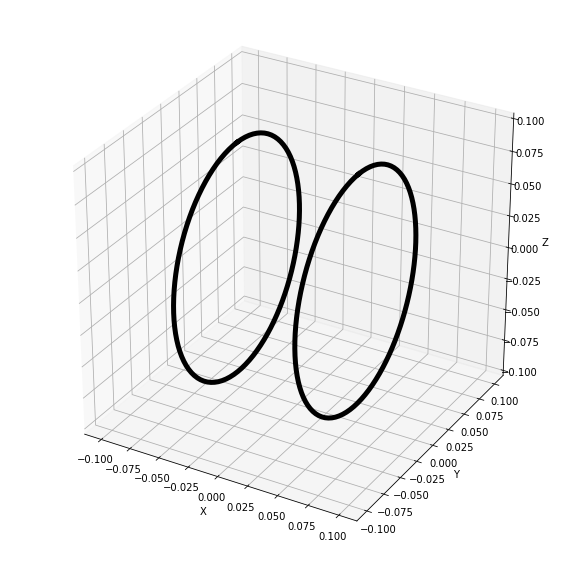

In [3]:
%matplotlib inline
import numpy as np
from numpy import r_, zeros, pi, mean
from math import sqrt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import warnings
warnings.filterwarnings('ignore')

N=6 #number of arrows per direction
NOP=100 #number of discrete elements per loop

x = np.linspace(-0.1,0.1,6)
y = np.linspace(-0.1,0.1,6)
z = np.linspace(-0.1,0.1,6)
x,y,z = np.meshgrid(x,y,z)
xx=x.ravel()
yy=y.ravel()
zz=z.ravel()
#where to evaluate the B field
points = [xx,yy,zz]

#For the Helmholtz coils 2 Loops of radius R in the yz plane 
coil_1 = Wire()
coil_2 = Wire()

R = .09 #m radius of both coils
Cx = 0.05 
C = [Cx , 0, 0] #center of coil 1 is 5 cm to the right
coil_1.Create_Loop(C, R, NOP,'yz')
coil_1.Set_Current(1.,0)

C = [-Cx , 0, 0] #center of coil 2 is 5 cm to the left
coil_2.Create_Loop(C, R, NOP,'yz')
coil_2.Set_Current(1.,0)

#Solve and get the norm of the B field
Solver = BSSolver()
B1=Solver.Solve(coil_1, points, 0.1)
B2=Solver.Solve(coil_2, points, 0.1)

#Superposition of both magnetic fields
B = B1 + B2

#Plot them in 3D
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
#Plot of the arrows
plt.quiver(xx,yy,zz,B[:,0],B[:,1],B[:,2],color='b',length=.04,normalize=False)
#Plot of the two coils
plt.plot(coil_1.coordz[0],coil_1.coordz[1],coil_1.coordz[2],color='k',linewidth=5)
plt.plot(coil_2.coordz[0],coil_2.coordz[1],coil_2.coordz[2],color='k',linewidth=5)
ax=plt.gca()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z');

Und dann die $(x,z)$ Ebene mit $y=0$ geplottet. Sie zeigt sehr schön, dass das Magentfeld relativ homogen zwischen dem Spulenpaar ist.

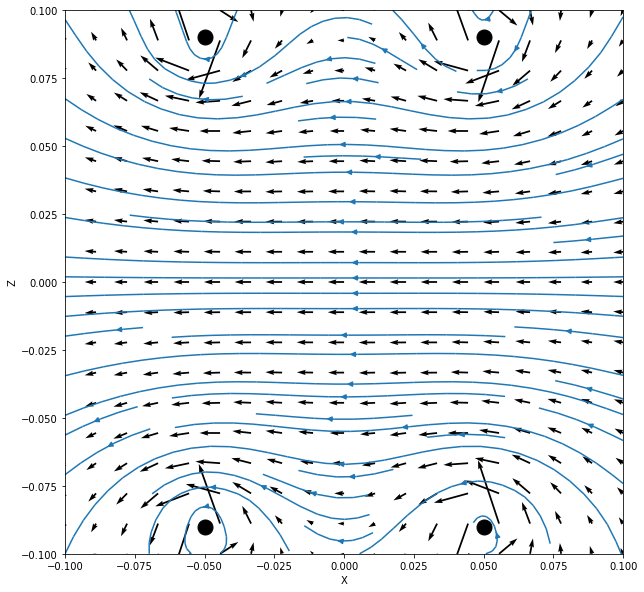

In [3]:
%matplotlib inline
N=19
x = np.linspace(-0.1,0.1,N)
z = np.linspace(-0.1,0.1,N)
x,z = np.meshgrid(x,z)
xx=x.ravel()
zz=z.ravel()
#where to evaluate the B field
points = [xx,np.zeros(len(xx)),zz]

Solver = BSSolver()
B1=Solver.Solve(coil_1, points, 0.1)
B2=Solver.Solve(coil_2, points, 0.1)
B=B1+B2

fig = plt.figure(figsize=(10,10))
plt.quiver(xx, zz, B[:,0], B[:,2],color='k')
plt.streamplot(x, z, B[:,0].reshape((N,N)), B[:,2].reshape((N,N)), density=[0.5, 1])
plt.plot(Cx,-R,'o',c='k',markersize=15);plt.plot(Cx,+R,'o',c='k',markersize=15);
plt.plot(-Cx,-R,'o',c='k',markersize=15);plt.plot(-Cx,+R,'o',c='k',markersize=15)
ax=plt.gca()
ax.set_xlabel('X')
ax.set_ylabel('Z');

Obiges Beispiel soll zum Spielen einladen. Sie können versuchen die Stromrichtung einer Spule zu ändern und sehen was sich für ein Magnetfeld ergibt. Die Stromrichtung wird mit dem Befehl ```coil.Set_Current(I,0)``` gesetzt wobei ```I``` für den Strom in Ampere steht. 
Dieses Magnetfeld wird dann Quadrupolfeld genannt. Warum? 

Weiterhin können sie komplexe Geometrien wie eine lange Spule, geknickte Drähte, oder eine Toroidspule rechnen. Schauen Sie sich dazu die Definitionen für verschiedene Geometrien unten an. Viel Spass bei den Rechnungen.

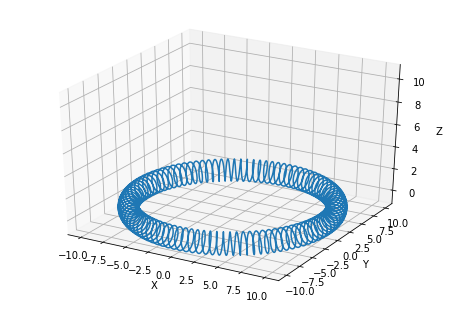

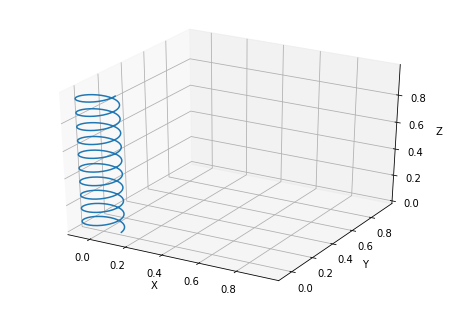

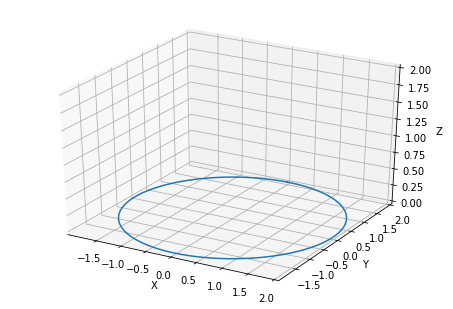

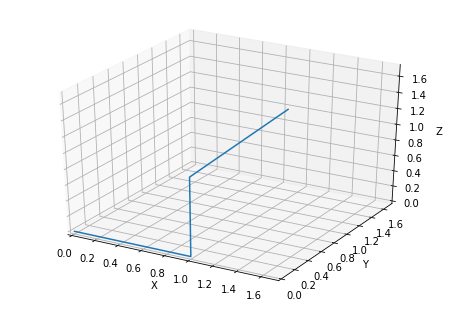

In [4]:
from numpy import pi,array

myShape = Wire()

#Toroidal solenoid
myShape.plotme()

#Solenoid
N = 10;
l = 1;
R = 0.1;
step = 0.1
myShape.Create_Solenoid(R, N, l, step)
myShape.plotme()

#loop
R = 2
C = [0,0,0]
NOP = 100
myShape.Create_Loop(C, R, NOP)
myShape.plotme()

#segmented wire
myShape.coordz=[]
myShape.AugmentWire( pi/2, 0, 1,array([0,0,0]))
myShape.AugmentWire( 0, 0, 1)
myShape.AugmentWire( pi/4, pi/4, 1)
myShape.plotme()

myShape.ShowPlots()